In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
plt.rc('font', family='NanumGothic')
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.

In [3]:
df = pd.read_csv('./sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3969,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000
3970,2020-10-09,3459.669922,3482.340088,3458.070068,3477.139893,3477.139893,3939060000
3971,2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,3428970000
3972,2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,3605150000
3973,2020-10-14,3515.469971,3527.939941,3480.550049,3489.070068,3489.070068,1087883110


In [4]:
df.set_index('Date', inplace=True)
df = df['Adj Close']

In [6]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [7]:
look_back = 30
forward_days = 7
num_periods = 50
scl = MinMaxScaler()
array = df.values.reshape(df.shape[0],1)
array = scl.fit_transform(array)
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]
array_train = array[:division]

X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20)

In [8]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(2870, 30, 1)
(718, 30, 1)
(50, 30, 1)
(2870, 7)
(718, 7)
(50, 7)


In [9]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Epoch 1/50
1435/1435 - 12s - loss: 0.0017 - val_loss: 4.0339e-04
Epoch 2/50
1435/1435 - 11s - loss: 3.9068e-04 - val_loss: 9.8803e-04
Epoch 3/50
1435/1435 - 11s - loss: 2.8389e-04 - val_loss: 4.5023e-04
Epoch 4/50
1435/1435 - 11s - loss: 2.6240e-04 - val_loss: 4.2806e-04
Epoch 5/50
1435/1435 - 11s - loss: 2.2608e-04 - val_loss: 5.3140e-04
Epoch 6/50
1435/1435 - 11s - loss: 2.0739e-04 - val_loss: 3.2157e-04
Epoch 7/50
1435/1435 - 11s - loss: 2.0487e-04 - val_loss: 1.6473e-04
Epoch 8/50
1435/1435 - 11s - loss: 1.8908e-04 - val_loss: 1.5945e-04
Epoch 9/50
1435/1435 - 11s - loss: 1.8105e-04 - val_loss: 1.4853e-04
Epoch 10/50
1435/1435 - 11s - loss: 1.7062e-04 - val_loss: 1.3866e-04
Epoch 11/50
1435/1435 - 11s - loss: 1.6636e-04 - val_loss: 2.0977e-04
Epoch 12/50
1435/1435 - 11s - loss: 1.6109e-04 - val_loss: 1.5590e-04
Epoch 13/50
1435/1435 - 11s - loss: 1.5400e-04 - val_loss: 1.6665e-04
Epoch 14/50
1435/1435 - 11s - loss: 1.5284e-04 - val_loss: 1.7809e-04
Epoch 15/50
1435/1435 - 11s - los

In [10]:
Xt = model.predict(X_test)

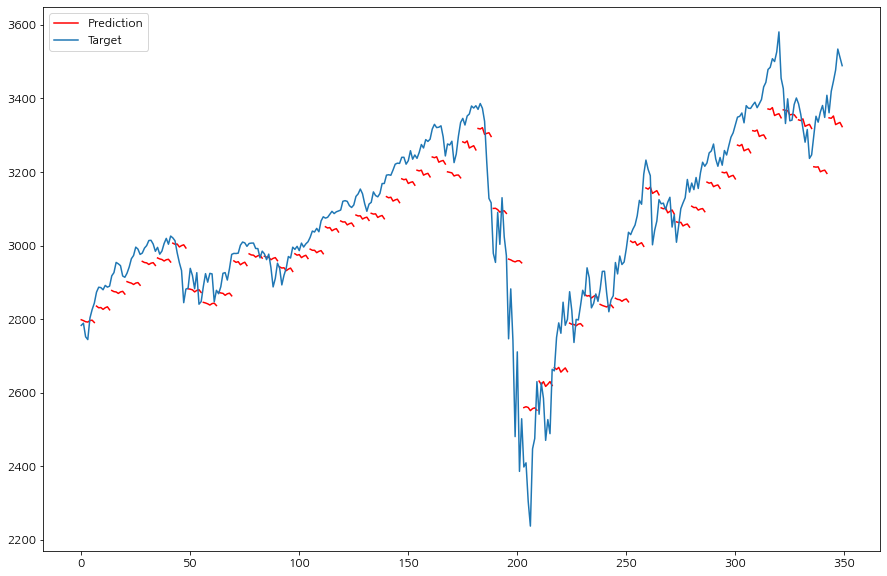

In [11]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction')
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()